## Helper Methods
- Tools we may use later for data pre-processing and graphing

In [123]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from pathlib import Path
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, concatenate, Lambda, BatchNormalization, Activation, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, mean_squared_error
import matplotlib.pyplot as plt 
from collections.abc import Sequence
from sklearn import preprocessing
%matplotlib inline
from IPython.display import Image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preproc
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

BASE_PATH = "./"

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,sort = True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by = ['y'],inplace = True)
    a = plt.plot(t['pred'].tolist(), ls = '', marker='s', markersize = 1.0, label = 'prediction', color = 'orange')
    b = plt.plot(t['y'].tolist(), label = 'expected', color = 'blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
#custom function for sliding window x/y data split
def create_sliding_window_data(df, close_unnormalized, window_size):
    x = []
    y = []
    for i in range(window_size, len(df)):
        #get window_size days of data (rows i-window_size to i-1)
        window = df.iloc[i-window_size:i].values
        x.append(window.flatten())
        y.append(close_unnormalized[i])
    return np.array(x), np.array(y)


## Set up Environment
Create test output folders and define paths 

In [124]:
base_path=os.path.join(os.getcwd(), './test-output/')

iteration='iteration-2'
full_path = os.path.join(base_path, iteration)
try:
        os.mkdir(base_path)
except Exception as e:
     print(f"Probably safe to ignore the following error: \n{e}")

#try:
#    os.mkdir(full_path)
#except Exception as e:
#    print(f"{e}\nExiting to protect previous work.")
#    sys.exit(0)
    

Probably safe to ignore the following error: 
[WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\admin\\Documents\\CSC180\\Assignment-4\\ECVersion\\bchurch2-Time-Series-Forecasting\\./test-output/'


## Data Extraction

In [134]:
#read dataset and format
from sklearn.model_selection import train_test_split
TXT_DATASET_LOCATION = "./business-dataset/AAPL.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)




split_raw = int(len(df) * 0.7)
df_train = df.iloc[:split_raw].copy()
df_test  = df.iloc[split_raw:].copy()



train_means = {}
train_stds  = {}

for col in df_train.columns:
    mean = df_train[col].mean()
    sd   = df_train[col].std()
    train_means[col] = mean
    train_stds[col]  = sd

    # normalize TRAIN in place
    encode_numeric_zscore(df_train, col, mean=mean, sd=sd)
    # normalize TEST using the same mean/sd (no leakage)
    encode_numeric_zscore(df_test, col, mean=mean, sd=sd)

window_size = 7

# keep separate unnormalized close values for each split
close_train = df["Close"].iloc[:split_raw].values.copy()
close_test  = df["Close"].iloc[split_raw:].values.copy()

x_train, y_train = create_sliding_window_data(df_train, close_train, window_size)
x_test,  y_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#code no bueno
#for col in df.columns:
   # encode_numeric_zscore(df, col) 

#fix to lstm issue where test data starts cold


## Data Split

In [135]:
#XY split
'''
from sklearn.model_selection import train_test_split
x, y = create_sliding_window_data(df, close_unnormalized, window_size=7)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, shuffle=False, random_state=42
) '''

window_size = 7
n_features = 5

#creating split for each model 
#Base aka FCNN
x_train_flat, y_train_base = x_train.copy(), y_train.copy()
x_test_flat, y_test_base = x_test.copy(), y_test.copy()

x_train_cnn = x_train.reshape(-1, 7, 5, 1)
x_test_cnn = x_test.reshape(-1, 7, 5, 1)

#for LSTM (3D) 
x_train_lstm = x_train.reshape(-1, 7, 5)
x_test_lstm = x_test.reshape(-1, 7, 5)



## LSTM Model

In [127]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
#save the best model
window_size = 7
n_features = 5

# Reshape for LSTM
#x = x.reshape(-1, window_size, n_features)

#LSTM checkpoint
LSTMcheckpointer = ModelCheckpoint(filepath=full_path + "/best_LSTMweights.keras", monitor="val_loss", save_best_only = True) 
#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(5):
    print(i)
    #build the network
    LSTM_model = Sequential()

    LSTM_model.add(Bidirectional((LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(window_size, n_features)))))
   # LSTM_model.add(Dropout(0.3))
    LSTM_model.add(LSTM(32, return_sequences=False, dropout=0.1, recurrent_dropout=0.0))
    LSTM_model.add(Dense(32, activation="tanh"))
    LSTM_model.add(Dropout(0.1))
    LSTM_model.add(Dense(1))
   

    #model compilation
    LSTM_model.compile(loss = 'mean_squared_error', optimizer = Adam(1e-3))
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1, mode="auto")
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model



# Train correct model
history = LSTM_model.fit(
    x_train_lstm, y_train_base,
    validation_data=(x_test_lstm, y_test_base),
    epochs=1000,
    batch_size=64,
    shuffle=True,
    callbacks=[LSTMcheckpointer, monitor],
    verbose=1
)
print('Training finished...Loading the best model')  
print()


0
1
2
3
4
Epoch 1/1000


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 2.9702 - val_loss: 7895.0103
Epoch 2/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5864 - val_loss: 7646.6499
Epoch 3/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3680 - val_loss: 7512.2603
Epoch 4/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2717 - val_loss: 7407.8525
Epoch 5/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2338 - val_loss: 7337.4468
Epoch 6/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2262 - val_loss: 7281.0957
Epoch 7/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1898 - val_loss: 7237.9805
Epoch 8/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1856 - val_loss: 7193.8037
Epoch 9/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1622 - val_loss: 7161.7739
Epoch 10/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1506 - val_loss: 7130.0518
Epoch 11/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1606 - val_loss: 7104.543

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Score (RMSE): 81.62071985210589


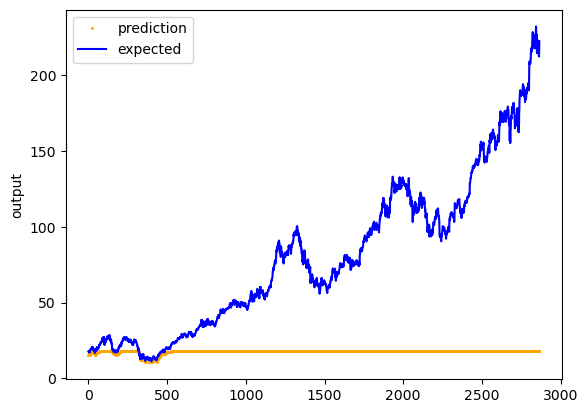

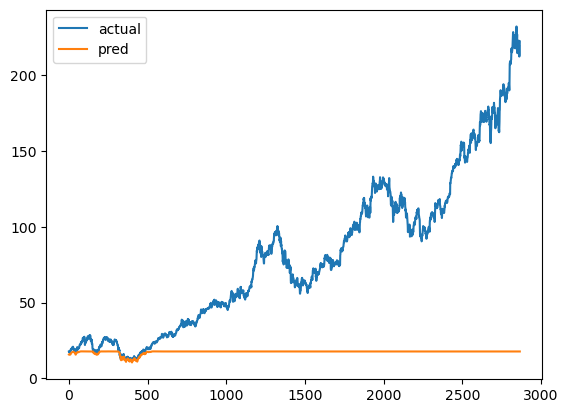

(2866, 1)


In [128]:
LSTM_model.load_weights(full_path + '/best_LSTMweights.keras')
y_pred_lstm= LSTM_model.predict(x_test_lstm)

#rmse score
rmse = np.sqrt(metrics.mean_squared_error(y_test_base,y_pred_lstm))
print("Score (RMSE): {}".format(rmse))
chart_regression(y_pred_lstm.flatten(),y_test_base, sort = False)

plt.plot(y_test_base, label="actual")
plt.plot(y_pred_lstm.flatten(), label="pred")
plt.legend(); plt.show()
print(y_pred_lstm.shape)


## FCNN Model


In [136]:
#save the best model
checkpointer = ModelCheckpoint(filepath= full_path + "/best_FCNNweights1.keras", verbose = 0, save_best_only = True) 
#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(1):
    print(i)
    #build the network
    model = Sequential()
    model.add(Dense(64, input_dim = x_train_flat.shape[1], activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
   

    #model compilation
    model.compile(loss = 'mean_squared_error', optimizer = optimizer)
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model
    history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 190, batch_size = 64, shuffle=True, callbacks = [monitor, checkpointer], verbose = 1)
    print('Training finished...Loading the best model')  
    print()

    

0


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.3740 - val_loss: 1708.1113
Epoch 2/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6847 - val_loss: 9.0141
Epoch 3/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7049 - val_loss: 42.6033
Epoch 4/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5902 - val_loss: 39.4369
Epoch 5/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5272 - val_loss: 25.1718
Epoch 6/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2163 - val_loss: 26.6397
Epoch 7/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1852 - val_loss: 87.9816
Epoch 8/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0096 - val_loss: 155.3810
Epoch 9/190
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9479 - val_loss: 62.0769
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 2.
Training finished...Loading the best model



In [137]:
model.load_weights(full_path + '/best_FCNNweights1.keras')

## FCNN Graphing

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(2860, 1)
Score (RMSE): 3.002344097561536


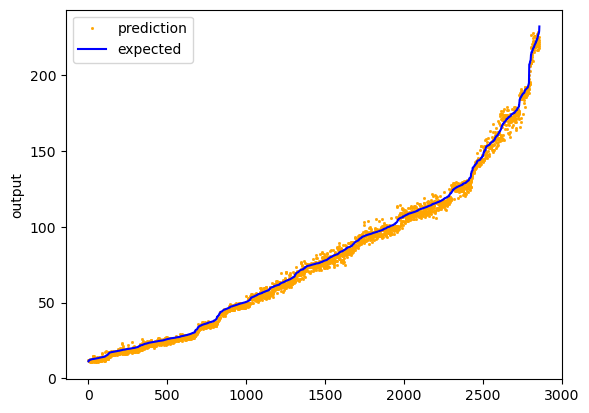

In [138]:
#make predictions
y_pred = model.predict(x_test_flat)
print(y_pred.shape)

#rmse score
rmse = np.sqrt(metrics.mean_squared_error(y_test_base, y_pred))
print("Score (RMSE): {}".format(rmse))
chart_regression(y_pred.flatten(),y_test_base, sort = True)

In [ ]:
x_train.shape

(6681, 35)

## CNN Model


In [ ]:

#save the best model
CNNcheckpointer = ModelCheckpoint(filepath= full_path + "/best_CNNweights.keras", verbose = 0, save_best_only = True) 

#reshape for CNN
#Not certain if this is the best approach, mainly just done to avoid error
#need to not do this lol

#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(1):
    print(i)
    #build the network

    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                        input_shape=(7, 5, 1)))
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.25))

    CNN_model.add(Flatten())
    CNN_model.add(Dense(64, activation="relu"))
    CNN_model.add(Dropout(0.25))
    CNN_model.add(Dense(1, activation="linear"))
    

#model compilation
CNN_model.compile(loss = 'mean_squared_error', optimizer = optimizer)
#early stopping
monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
#optimizer
optimizer = Adam(learning_rate = 0.0001)

#train model

#Train correct model
history = CNN_model.fit(
    x_train_cnn, y_train_base,
    validation_data=(x_test_cnn, y_test_base),
    epochs=1000,
    batch_size=64,
    shuffle=True,
    callbacks=[CNNcheckpointer, monitor],
    verbose=1
)
print('Training finished...Loading the best model')  
print()


0


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.1751 - val_loss: 42.8344
Epoch 2/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1723 - val_loss: 156.6209
Epoch 3/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9173 - val_loss: 211.6808
Epoch 4/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6812 - val_loss: 231.1028
Epoch 5/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5238 - val_loss: 365.7903
Epoch 6/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4183 - val_loss: 139.4465
Epoch 7/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3538 - val_loss: 124.7013
Epoch 8/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3253 - val_loss: 93.0215
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Training finished...Loading the best model



90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(2860, 1)
Score (RMSE): 6.544803166760647


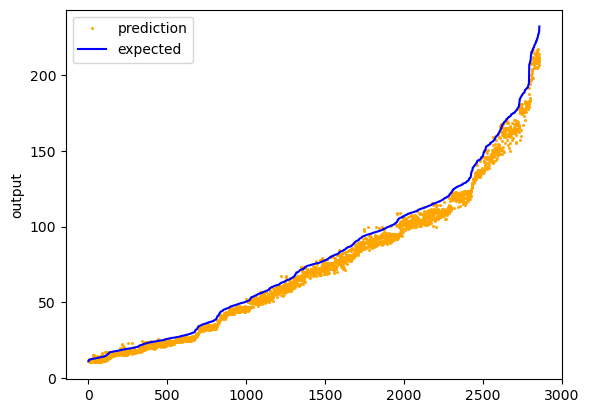

In [ ]:
CNN_model.load_weights(full_path + '/best_CNNweights.keras')
y_other_pred = CNN_model.predict(x_test_cnn)
print(y_other_pred.shape)

#rmse score
score = np.sqrt(metrics.mean_squared_error(y_test_base,y_other_pred))
print("Score (RMSE): {}".format(score))
chart_regression(y_other_pred.flatten(),y_test_base, sort = True)


In [ ]:
x_train[1:4]

array([[[-0.54819953, -0.54893537, -0.54725828, -0.50388387,
         -0.5481316 ],
        [-0.5489768 , -0.54970621, -0.5480422 , -0.70572994,
         -0.54890874],
        [-0.54878248, -0.54946531, -0.54779722, -0.76121828,
         -0.54866587],
        [-0.54849102, -0.54917625, -0.54750326, -0.79859718,
         -0.54837446],
        [-0.54785948, -0.54854996, -0.54686632, -0.87000378,
         -0.54774303],
        [-0.54732509, -0.54801999, -0.54632737, -0.90242031,
         -0.54720873],
        [-0.5468393 , -0.54753823, -0.54583743, -0.87483726,
         -0.54672302]],

       [[-0.5489768 , -0.54970621, -0.5480422 , -0.70572994,
         -0.54890874],
        [-0.54878248, -0.54946531, -0.54779722, -0.76121828,
         -0.54866587],
        [-0.54849102, -0.54917625, -0.54750326, -0.79859718,
         -0.54837446],
        [-0.54785948, -0.54854996, -0.54686632, -0.87000378,
         -0.54774303],
        [-0.54732509, -0.54801999, -0.54632737, -0.90242031,
         -0.5

## EC: RMSE Against N Value
Using the FCNN

In [ ]:
#read dataset and format
TXT_DATASET_LOCATION = "./business-dataset/AAPL.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)

#normalize data (separate from close_unnormalized)
for col in df.columns:
    encode_numeric_zscore(df, col)

### Window size 3

In [ ]:
#save the best model
checkpointer = ModelCheckpoint(filepath= full_path + "/best_FCNNweights2.keras", verbose = 0, save_best_only = True) 

window_size = 7
x, y = create_sliding_window_data(df, close_unnormalized, window_size=window_size)

# chronological split (no leakage, no shuffle)
split = int(len(x) * 0.70)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    #model defenition
    model1 = Sequential()
    model1.add(Dense(64, input_dim=x1_train.shape[1], activation="relu"))
    model1.add(Dropout(0.3))
    model1.add(Dense(32, activation="relu"))
    model1.add(Dropout(0.2))
    model1.add(Dense(16, activation="relu"))
    model1.add(Dense(1, activation="linear"))

    #model compilation
    model1.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history1 = model1.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
print('Training finished...Loading the best model')
print()


NameError: name 'x1_train' is not defined

### Window size 5

In [ ]:
#save the best model
checkpointer = ModelCheckpoint(filepath=full_path + "/best_FCNNweights3.keras", verbose = 0, save_best_only = True) 

x2, y2 = create_sliding_window_data(df, close_unnormalized, window_size=5)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    #model defenition
    model2 = Sequential()
    model2.add(Dense(64, input_dim=x2_train.shape[1], activation="relu"))
    model2.add(Dropout(0.3))
    model2.add(Dense(32, activation="relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(16, activation="relu"))
    model2.add(Dense(1, activation="linear"))

    #model compilation
    model2.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history2 = model2.fit(x2_train, y2_train, validation_data=(x2_test, y2_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
    
#track the best model across all runs
current_val_loss = min(history2.history['val_loss'])
if current_val_loss < best_val_loss:
    best_val_loss = current_val_loss
    model2.save( full_path + "/best_FCNNweights3.keras")
    print(f"Iteration {i}: New best model saved (val_loss: {best_val_loss:.6f})")
print('Training finished...Loading the best model')
print()

/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 44.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 76.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 51.
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 57.
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 91.
Epoch 105: early stopping
Restoring model weights from the end of the best epoch: 98.
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 77.
Epoch 119: early stopping
Restoring model weights from the end of the best epoch: 112.
Iteration 9: New best model saved (val_loss: 2.087944)
Training finished...Loading the best model



### Window size 7

In [ ]:
#save the best model
checkpointer = ModelCheckpoint(filepath=full_path + "/best_FCNNweights4.keras", verbose = 0, save_best_only = True) 

x3, y3 = create_sliding_window_data(df, close_unnormalized, window_size=7)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    #model defenition
    model3 = Sequential()
    model3.add(Dense(64, input_dim=x3_train.shape[1], activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32, activation="relu"))
    model3.add(Dropout(0.2))
    model3.add(Dense(16, activation="relu"))
    model3.add(Dense(1, activation="linear"))

    #model compilation
    model3.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history3 = model3.fit(x3_train, y3_train, validation_data=(x3_test, y3_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
print('Training finished...Loading the best model')
print()

Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 85.
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 66.
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 80.
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 123: early stopping
Restoring model weights from the end of the best epoch: 116.
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 85.
Epoch 102: early stopping
Restoring model weights from the end of the best epoch: 95.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 76.
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 78.
Training finished...Loading the best model



### Window size 9

In [ ]:
#save the best model
checkpointer = ModelCheckpoint(filepath= full_path + "/best_FCNNweights5.keras", verbose = 0, save_best_only = True) 

x4, y4 = create_sliding_window_data(df, close_unnormalized, window_size=9)
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    #model defenition
    model4 = Sequential()
    model4.add(Dense(64, input_dim=x4_train.shape[1], activation="relu"))
    model4.add(Dropout(0.3))
    model4.add(Dense(32, activation="relu"))
    model4.add(Dropout(0.2))
    model4.add(Dense(16, activation="relu"))
    model4.add(Dense(1, activation="linear"))

    #model compilation
    model4.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history4 = model4.fit(x4_train, y4_train, validation_data=(x4_test, y4_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
print('Training finished...Loading the best model')
print()

Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 102: early stopping
Restoring model weights from the end of the best epoch: 95.
Epoch 101: early stopping
Restoring model weights from the end of the best epoch: 94.
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 54.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 79.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 79.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 67.
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 73.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 67.
Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 117.
Training finished...Loading the best model



### Window size 11

In [ ]:
#save the best model
checkpointer = ModelCheckpoint(filepath=full_path + "/best_FCNNweights6.keras", verbose = 0, save_best_only = True) 

x5, y5 = create_sliding_window_data(df, close_unnormalized, window_size=11)
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, y5, test_size=0.30, random_state=42)

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate = 0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    #model defenition
    model5 = Sequential()
    model5.add(Dense(64, input_dim=x5_train.shape[1], activation="relu"))
    model5.add(Dropout(0.3))
    model5.add(Dense(32, activation="relu"))
    model5.add(Dropout(0.2))
    model5.add(Dense(16, activation="relu"))
    model5.add(Dense(1, activation="linear"))

    #model compilation
    model5.compile(loss='mean_squared_error', optimizer=optimizer)

    #train model
    history5 = model5.fit(x5_train, y5_train, validation_data=(x5_test, y5_test), epochs=1000, batch_size=64, callbacks=[monitor, checkpointer], verbose=0)
print('Training finished...Loading the best model')
print()

Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 79.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 30.
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 77.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 69.
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 69.
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 75.
Epoch 101: early stopping
Restoring model weights from the end of the best epoch: 94.
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 82.
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 78.
Training finished...Loading the best model



Window Size: 3
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
(2866, 1)
Score (RMSE): 1.4684977896033116
Window Size: 5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
(2865, 1)
Score (RMSE): 1.4449718946071015
Window Size: 7
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
(2865, 1)
Score (RMSE): 1.5288868216220095
Window Size: 9
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
(2864, 1)
Score (RMSE): 1.7594201985018243
Window Size: 11
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
(2864, 1)
Score (RMSE): 1.9856184136533341


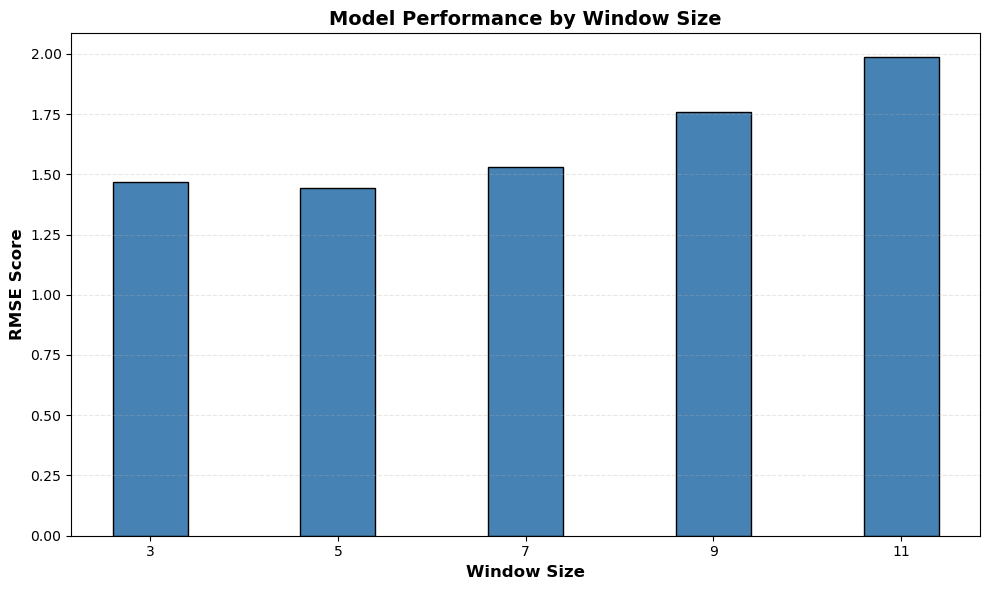

SUMMARY
Best Window Size: 5
Best RMSE Score: 1.4450


In [ ]:
#stored weights and models
window_sizes = [3, 5, 7, 9, 11]
models = [model1, model2, model3, model4, model5]
weight_files = [
    (full_path + '/best_FCNNECweights2.keras'),
    (full_path + '/best_FCNNECweights3.keras'),
    (full_path + '/best_FCNNECweights4.keras'),
    (full_path + '/best_FCNNECweights5.keras'),
    (full_path + '/best_FCNNECweights6.keras')
]
#test data
test_sets = [(x1_test, y1_test), (x2_test, y2_test), (x3_test, y3_test), 
             (x4_test, y4_test), (x5_test, y5_test)]

#storage for RMSE scores
scores = []

#recursively evaluate each model
for i, (ws, model, weights, (x_test, y_test)) in enumerate(zip(window_sizes, models, weight_files, test_sets)):
    print(f"\033[1m\033[4mWindow Size: {ws}\033[0m")
    model.load_weights(weights)
    y_pred = model.predict(x_test)
    print(y_pred.shape)
    
    #calculate RMSE
    score = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
    scores.append(score)
    print(f"Score (RMSE): {score}")

#create bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(window_sizes, scores, color='steelblue', edgecolor='black')

plt.xlabel('Window Size', fontsize=12, fontweight='bold')
plt.ylabel('RMSE Score', fontsize=12, fontweight='bold')
plt.title('Model Performance by Window Size', fontsize=14, fontweight='bold')
plt.xticks(window_sizes)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#data summary
print("SUMMARY")
best_idx = np.argmin(scores)
print(f"Best Window Size: {window_sizes[best_idx]}")
print(f"Best RMSE Score: {scores[best_idx]:.4f}")